In [1]:
from numpy import zeros,ones,exp,sort,conj,array,argsort,log,dot,tensordot,outer,reshape,swapaxes,angle,pi
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from numpy.random import rand
from scipy import integrate
from numpy.linalg import norm,eig,solve,svd
# from copy import deepcopy
# from sklearn.linear_model import LinearRegression
def mylog(x):
	if x <= 0:
		return - 1000000
	else:
		return log(x)

spin_eigens = []
spin_eigens.append(array([[1., 0],[0, 1.]]))
spin_eigens.append(array([[1., -1.],[1., 1.]]) / 2 ** 0.5)
spin_eigens.append(array([[1., -1.j],[-1.j, 1]]) / 2 ** 0.5)
#012 : zxy


class MPS(object):
	def __init__(self, space_size, initial_state_type, hamiltonian, theta, gg):
		self.energy = 1j
		self.space_size = space_size
		self.state_number = 2 ** space_size
		self.cutoff = 0.0000001
		self.indstate = [self.ind2state(i) for i in range(self.state_number)]
		# 编号->state, 10->2

		if hamiltonian == "ising":
			# MPO for transverse ising model
			self.ham = []
			self.J = -1
			self.H = 0.01
			S_x = np.zeros((2,2))
			S_x[0][1] = 1
			S_x[1][0] = 1

			S_y = np.array([[0, -1.j], [1.j, 0]])

			S_z = np.identity(2)
			S_z[1][1] = -1

			S_theta = np.cos(theta) * S_x + np.sin(theta) * S_y

			matrixM = np.zeros((3,2,2,3), dtype=complex)
			matrixM[0, :, :, 0] = np.identity(2)
			matrixM[1, :, :, 0] = - S_z
			matrixM[2, :, :, 0] = - self.H * S_theta
			matrixM[2, :, :, 1] = - self.J * S_z
			matrixM[2, :, :, 2] = np.identity(2)
			self.ham = [matrixM] * self.space_size
			self.hamleft = np.array([[0, 0, 1]])
			self.hamright = np.array([[1, 0, 0]])
			self.ham[0] = np.tensordot(self.hamleft, matrixM, axes = [1, 0])
			self.ham[self.space_size - 1] = np.tensordot(matrixM, self.hamright, axes = [3, 1])


		elif hamiltonian == "transverse":
			# MPO for transverse ising model
			self.ham = []
			self.g = gg
			S_x = np.zeros((2,2))
			S_x[0][1] = 1
			S_x[1][0] = 1

			S_y = np.array([[0, -1.j], [1.j, 0]])

			S_z = np.identity(2)
			S_z[1][1] = -1

			matrixM = np.zeros((5,2,2,5), dtype=complex)
			matrixM[0, :, :, 0] = np.identity(2)
			matrixM[1, :, :, 0] = S_x
			matrixM[2, :, :, 0] = S_y
			matrixM[3, :, :, 0] = S_z
			matrixM[4, :, :, 0] = self.g * S_z
			matrixM[4, :, :, 1] = -S_x
			matrixM[4, :, :, 2] = S_y/2.0
			matrixM[4, :, :, 3] = S_z/2.0
			matrixM[4, :, :, 4] = np.identity(2)


			self.ham = [matrixM] * self.space_size
			self.hamleft = np.array([[0, 0, 0, 0, 1]])
			self.hamright = np.array([[1, 0, 0, 0, 0]])
			self.ham[0] = np.tensordot(self.hamleft, matrixM, axes = [1, 0])
			self.ham[self.space_size - 1] = np.tensordot(matrixM, self.hamright, axes = [3, 1])

		if initial_state_type == "random":
			init_bond_dimension = 3
			self.bond_dimension = [init_bond_dimension] * self.space_size ## bond[i] connect i i+1
			self.bond_dimension[-1] = 1
			self.matrices = []
			for i in range(space_size):
				self.matrices.append(rand(self.bond_dimension[(i - 1) % self.space_size], 2, self.bond_dimension[i]) + rand(self.bond_dimension[(i - 1) % self.space_size], 2, self.bond_dimension[i]) * 1.j)


		self.merged_bond = -1
		#
		self.merged_matrix = []
		self.normalization_pointer = 0
		self.left_cano()
		self.Loss = []
		self.Losses = []
		self.leftenvironment = [[]] * (self.space_size)
		self.rightenvironment = [[]] * self.space_size
		lw = np.zeros(1).reshape(1, 1, 1, 1, 1, 1)
		lw[0, 0, 0, 0, 0, 0] = 1
		self.leftenvironment[0] = lw.copy()
		rw = lw.copy()
		self.rightenvironment[self.space_size - 1] = rw.copy()
		self.ent = 0

		for i in range(self.space_size - 1):
			lw = np.tensordot(self.leftenvironment[i], self.matrices[i], axes = [3, 0])
			lw = np.tensordot(lw, self.ham[i], axes = [[3, 5], [0, 1]])
			lw = np.tensordot(lw, self.matrices[i].conj(), [[3, 5], [0, 1]])
			self.leftenvironment[i + 1] = lw.copy()
	def ind2state(self, ind):
		state = zeros(self.space_size, dtype = 'int')
		for i in range(self.space_size):
			state[i] = int(ind % 2)
			ind //= 2
		return state
	def Give_Psi(self, state, direction_setting):
		if self.merged_bond == -1:
			left_bond = self.space_size - 1
			right_bond = 0
			current_matrix = tensordot(self.matrices[0], spin_eigens[direction_setting[0]][state[0]], ([1],[0]))
		else :
			left_bond = (self.merged_bond - 1) % self.space_size
			right_bond = (self.merged_bond + 1) % self.space_size
			direction1 = direction_setting[self.merged_bond]
			direction2 = direction_setting[(self.merged_bond + 1) % self.space_size]
			current_matrix = tensordot(self.merged_matrix, spin_eigens[direction1][state[self.merged_bond]], ([1],[0]))
			current_matrix = tensordot(current_matrix, spin_eigens[direction2][state[(self.merged_bond + 1) % self.space_size]], ([1],[0]))
		while right_bond != left_bond:
			next_bond = (right_bond + 1) % self.space_size
			next_direction = direction_setting[next_bond]
			next_matrix = tensordot(self.matrices[next_bond], spin_eigens[next_direction][state[next_bond]], ([1],[0]))
			current_matrix = dot(current_matrix, next_matrix)
			right_bond = next_bond

		p = np.sum(np.diag(current_matrix))
		return p
	def renormalize(self):
		if self.merged_bond == -1:
			nor = norm(self.matrices[self.normalization_pointer][:])
			self.matrices[self.normalization_pointer] /= nor
		else :
			nor = norm(self.merged_matrix)
			self.merged_matrix /= nor
		#print("ReNormalization Factor:", nor)
		return nor
	def merge_bond(self, bond):
		self.merged_bond = bond
		self.merged_matrix = tensordot(self.matrices[bond],self.matrices[(bond + 1) % self.space_size], ([2], [0]))
	def rebuild_bond(self, bond, sweeping_direction_is_right):
		self.merged_bond = -1
		# cutoff = 0.09 - 0.40 * min(self.Loss[-1], 0.2)
		U, s, V = svd(reshape(self.merged_matrix, (self.bond_dimension[(bond - 1) % self.space_size] * 2, 2 * self.bond_dimension[(bond + 1) % self.space_size])))

		# print("bond:", bond, s)

		current_bond_dimension = s.size
		for i in range(s.size):
			if s[i] < s[0] * self.cutoff:
				current_bond_dimension = i
				break
		current_bond_dimension = max(current_bond_dimension, 2)
		s = np.diag(s[:current_bond_dimension])

		if sweeping_direction_is_right:
			U = U[:,:current_bond_dimension]
			V = dot(s, V[:current_bond_dimension,:])
			self.normalization_pointer = (bond + 1) % self.space_size
		else:
			U = dot(U[:,:current_bond_dimension], s)
			V = V[:current_bond_dimension,:]
			self.normalization_pointer = bond

		self.bond_dimension[bond] = current_bond_dimension
		# print("bond dimensions:", self.bond_dimension)
		self.matrices[bond] = reshape(U, (self.bond_dimension[(bond - 1) % self.space_size], 2, self.bond_dimension[bond]))
		self.matrices[(bond + 1) % self.space_size] = reshape(V, (self.bond_dimension[bond], 2, self.bond_dimension[(bond + 1) % self.space_size]))

		self.renormalize()
		return np.diag(s)
	def left_cano(self):
		for bond in range(2 - self.space_size, self.space_size - 1):
			self.merge_bond(np.abs(bond))
			self.rebuild_bond(np.abs(bond), (bond>=0))

			#初始化左正则
	def sweep(self):
		# print("")
		N = self.space_size

		for i in range(N - 2, -1, -1):
			self.merge_bond(i)
			self.normalization_pointer = i
			lh = np.tensordot(self.leftenvironment[i], self.ham[i], axes = [4, 0])
			lh = np.tensordot(lh, self.ham[i + 1], axes = [7, 0])
			lh = np.tensordot(lh, self.rightenvironment[i + 1], axes = [9, 1])
			lh = lh[0, 0, 0, :, :, :, :, :, :, :, :, 0, 0, 0]
			lh = lh.swapaxes(1, 2)
			lh = lh.swapaxes(2, 4)
			lh = lh.swapaxes(3, 6)
			lh = lh.swapaxes(5, 6)
			dim = lh.shape
			localhamiltonian = lh.reshape(dim[0] * dim[1] * dim[2] * dim[3], dim[4] * dim[5] * dim[6] * dim[7])
			eigenValues, eigenVectors = np.linalg.eig(localhamiltonian)
			ind = np.argsort(eigenValues)[0]
			psi = eigenVectors.transpose()[ind]
			psi = psi.reshape(dim[0], dim[1], dim[2], dim[3])
			self.merged_matrix = psi.conj()
			self.renormalize()
			self.rebuild_bond(i, False)
			self.energy = eigenValues[ind]
			# rebuild right environment for site i + 1
			rw = np.tensordot(self.matrices[i + 1], self.ham[i + 1], axes = [1, 1])
			rw = np.tensordot(rw, self.matrices[i + 1].conj(), axes = [3, 1])
			rw = np.tensordot(rw, self.rightenvironment[i + 1], axes = [[1, 3, 5], [0, 1, 2]])
			self.rightenvironment[i] = rw.copy()
			# print(self.energy)

		for i in range(N - 2):
			self.merge_bond(i)
			self.normalization_pointer = i
			lh = np.tensordot(self.leftenvironment[i], self.ham[i], axes = [4, 0])
			lh = np.tensordot(lh, self.ham[i + 1], axes = [7, 0])
			lh = np.tensordot(lh, self.rightenvironment[i + 1], axes = [9, 1])
			lh = lh[0, 0, 0, :, :, :, :, :, :, :, :, 0, 0, 0]
			lh = lh.swapaxes(1, 2)
			lh = lh.swapaxes(2, 4)
			lh = lh.swapaxes(3, 6)
			lh = lh.swapaxes(5, 6)
			dim = lh.shape
			localhamiltonian = lh.reshape(dim[0] * dim[1] * dim[2] * dim[3], dim[4] * dim[5] * dim[6] * dim[7])
			eigenValues, eigenVectors = np.linalg.eig(localhamiltonian)
			ind = np.argsort(eigenValues)[0]
			psi = eigenVectors.transpose()[ind]
			psi = psi.reshape(dim[0], dim[1], dim[2], dim[3])
			self.merged_matrix = psi.conj()
			self.renormalize()
			self.rebuild_bond(i, True)
			self.energy = eigenValues[ind]
			lw = np.tensordot(self.matrices[i], self.ham[i], axes = [1, 1])
			lw = np.tensordot(lw, self.matrices[i].conj(), axes = [3, 1])
			lw = np.tensordot(self.leftenvironment[i], lw, axes = [[3, 4, 5], [0, 2, 4]])
			self.leftenvironment[i + 1] = lw.copy()
			# print(self.energy)
	def precise_ground_energy(self):
		N = self.space_size
		if (N <= 8):
			H = self.ham[0]
			for i in range(N - 1):
				H = np.tensordot(H, self.ham[i + 1], axes = [3, 0])
				H = H.swapaxes(2, 3)
				dim = H.shape
				H = H.reshape(dim[0], dim[1] * dim[2], dim[3] * dim[4], dim[5])
			eigenValues, eigenVectors = np.linalg.eig(H[0, :, :, 0])
			ind = np.argsort(eigenValues)[0]
			print(eigenValues[ind])
			# print(eigenVectors.transpose()[ind])

	def entropy(self):
		N = self.space_size
		j = int(N/2.)
		psi = np.tensordot(self.matrices[j-1], self.matrices[j], axes = [2,0])
		dim = psi.shape
		psi = psi.reshape(dim[0] * dim[1], dim[2] * dim[3])
		U, s, V = svd(psi)
		print(s)
		self.ent = sum(-2 * l**2 * mylog(l) for l in s)
		

	def magnetization(self):
		N = self.space_size
		S_z = np.identity(2)
		S_z[1][1] = -1
		matrixM = np.zeros((2,2,2,2), dtype=complex)
		matrixM[0, :, :, 0] = np.identity(2)
		matrixM[1, :, :, 0] = S_z
		matrixM[1, :, :, 1] = np.identity(2)
		self.sz = [matrixM] * self.space_size
		self.szleft = np.array([[0, 1]])
		self.szright = np.array([[1, 0]])
		self.sz[0] = np.tensordot(self.szleft, matrixM, axes = [1, 0])
		self.sz[self.space_size - 1] = np.tensordot(matrixM, self.szright, axes = [3, 1])
		self.mag = [[[[[[1]]]]]]
		for i in range(N):
			temp = np.tensordot(self.matrices[i], self.sz[i], axes = [1, 1])
			temp = np.tensordot(temp, self.matrices[i].conj(), axes = [3, 1])
			self.mag = np.tensordot(self.mag, temp, axes = [[3, 4, 5], [0, 2, 4]])
		self.mag=self.mag[0][0][0][0][0][0]
            

In [12]:
mag10 = []
for i in range(10):
	mps = MPS(20, "random", "transverse", 0, i/5.)
	mps.cutoff = 0.0001
	for j in range(10):
		mps.sweep()
	mps.magnetization()
	#print(mps.g, mps.mag, mps.bond_dimension)
	print(mps.g, mps.mag)
	mag10.append([mps.g, mps.mag])

0.0 (-6.27462264513e-15+4.45365422168e-35j)
0.2 (-1.51970450167+1.24460305557e-60j)
0.4 (-3.06732912669-3.18618382226e-58j)
0.6 (-4.68289877128+0j)
0.8 (-6.43261320494+1.95602259977e-35j)
1.0 (-8.49036524386+2.75700407073e-25j)
1.2 (-11.246082658+2.20653031256e-19j)
1.4 (-13.5680229253-1.4541212718e-19j)
1.6 (-15.0197848735+6.39658820912e-22j)
1.8 (-16.0177646375+3.27952363821e-20j)


In [13]:
mag10=np.array(mag10)

In [7]:
from scipy import integrate
f = lambda k,gz : (gz+np.cos(k))/np.sqrt(1+gz**2+2*gz*np.cos(k))/np.pi


In [8]:
mz_exact=[]
glist=mag10[:,0]
for g in glist:
    mz_exact.append(integrate.quad(f, 0, np.pi, args=(g,))[0])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/integrate/quadpack.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


<IPython.core.display.Javascript object>


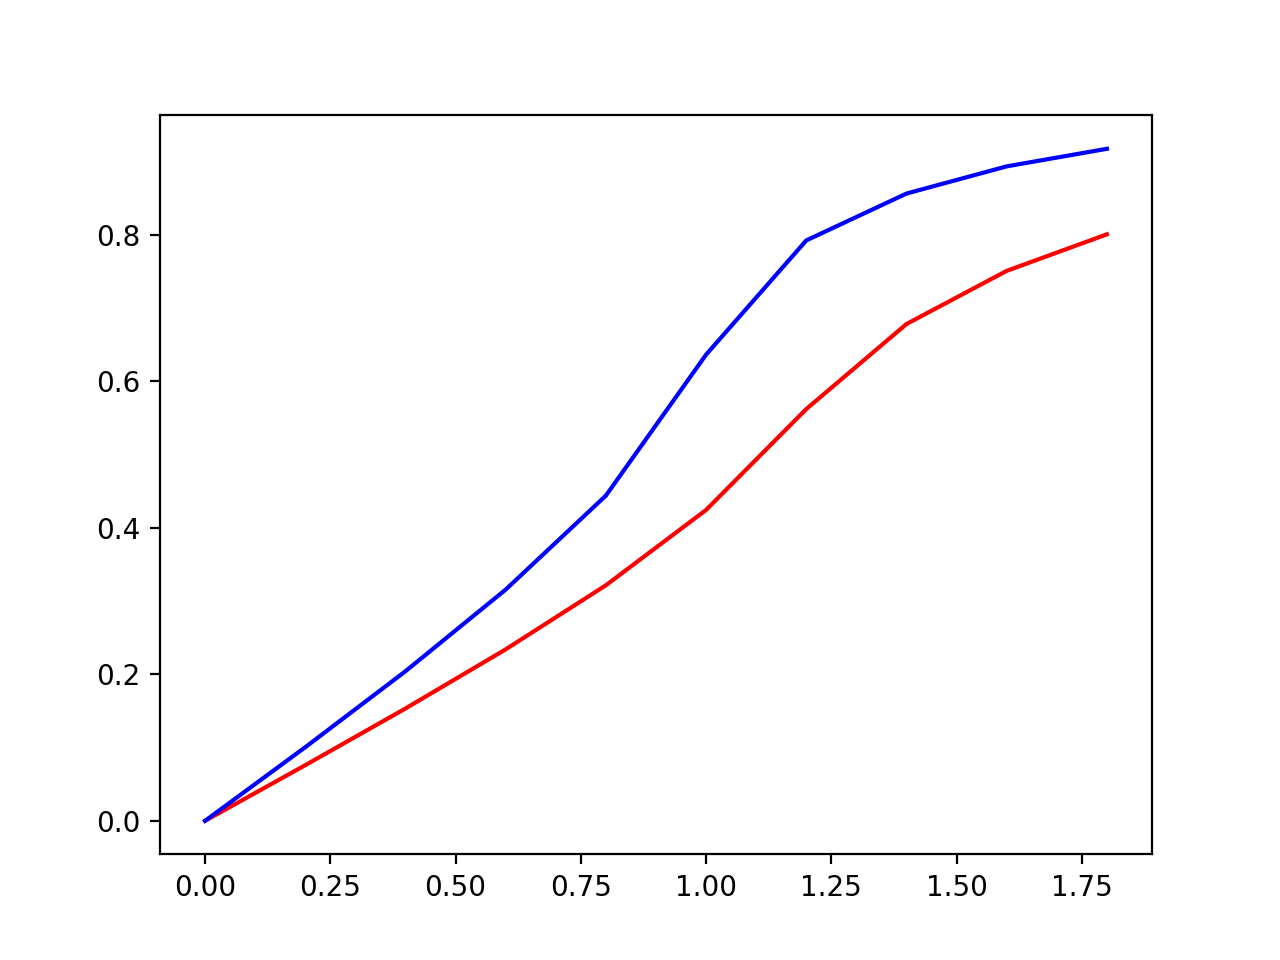

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [14]:
plt.figure(1)
plt.plot(mag10[:,0],-np.real(mag10[:,1])/mps.space_size,'r')
plt.plot(mag10[:,0],mz_exact,'b')
plt.show()

c:\users\laser\miniconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\laser\miniconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


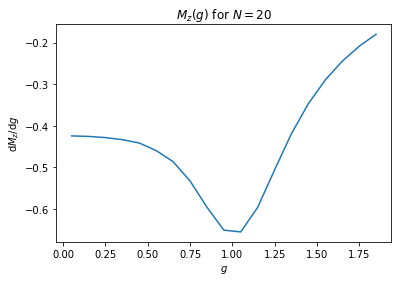

In [35]:
fig=plt.figure(2)
plt.plot([(mag10[j][0] + mag10[j+1][0])/2. for j in range(len(mag10)-1)], [-mag10[j][1] + mag10[j+1][1] for j in range(len(mag10)-1)])
ax = fig.add_subplot(111)
ax.set_title('$M_z(g)$ for $N=20$')
ax.set_xlabel('$g$')
ax.set_ylabel('$\mathrm{d}M_z/\mathrm{d}g$')
plt.show()